In [1]:
using JupyterFormatter
enable_autoformat()

using JuliaFormatter
format("./Simulation.jl", margin = 120);

In [2]:
using DataFrames
using Graphs
using LinearAlgebra
using Plots
using Random
using StatsBase
using Test: @testset, @test

include("./Simulation.jl")
using .Simulation

In [3]:
@testset "invert" begin
    @test invert(C) == D
    @test invert(D) == C
end

@testset "Model" begin
    @testset "default" begin
        model = Model()

        # agents
        @test model.agents.strategy == fill(D, 1_000)
        @test model.agents.payoff == fill(0.0, 1_000)

        # graph_weights
        @test model.initial_graph_weight == 0.5
        @test model.graph_weights == fill(0.5, (1_000, 1_000)) - Diagonal(fill(0.5, 1_000))

        # misc
        @test model.payoff_table[(C, C)] == (1.0, 1.0)
        @test model.payoff_table[(C, D)] == (-0.1, 1.1)
        @test model.payoff_table[(D, C)] == (1.1, -0.1)
        @test model.payoff_table[(D, D)] == (0.0, 0.0)
        @test model.interaction_freqency == 1.0
        @test model.relationship_volatility == 0.1
        @test model.reproduction_rate == 0.1
        @test model.δ == 0.01
        @test model.μ == 0.00
        @test isa(model.rng, MersenneTwister)
    end
    @testset "customized" begin
        model = Model(
            N = 255,
            initial_graph_weight = 0.123,
            T = 3.3,
            S = 2.2,
            interaction_freqency = 0.111,
            relationship_volatility = 0.19,
            reproduction_rate = 0.56,
            δ = 0.23,
            μ = 0.45,
        )

        # agents
        @test model.agents.strategy == fill(D, 255)
        @test model.agents.payoff == fill(0.0, 255)

        # graph_weights
        @test model.initial_graph_weight == 0.123
        @test model.graph_weights ==
              Float16.(fill(0.123, (255, 255)) - Diagonal(fill(0.123, 255)))

        # misc
        @test model.payoff_table[(C, C)] == (1.0, 1.0)
        @test model.payoff_table[(C, D)] == (2.2, 3.3)
        @test model.payoff_table[(D, C)] == (3.3, 2.2)
        @test model.payoff_table[(D, D)] == (0.0, 0.0)
        @test model.interaction_freqency == 0.111
        @test model.relationship_volatility == 0.19
        @test model.reproduction_rate == 0.56
        @test model.δ == 0.23
        @test model.μ == 0.45
    end
end;

Test Summary: | Pass  Total  Time
invert        |    2      2  0.7s
Test Summary: | Pass  Total  Time
Model         |   27     27  0.3s


In [4]:
@testset "interaction!" begin
    @testset "C vs. C" begin
        model = Model(N = 2, relationship_volatility = 0.2)
        model.agents[1, :strategy] = C
        model.agents[2, :strategy] = C
        interaction!(model)

        @test model.agents[1, :payoff] == 2.0
        @test model.agents[2, :payoff] == 2.0
        @test model.graph_weights[1, 2] == Float16(0.5 * 1.2 * 1.2)
        @test model.graph_weights == transpose(model.graph_weights)

        # check weight limit
        model = Model(N = 2, relationship_volatility = 0.9)
        model.agents[1, :strategy] = C
        model.agents[2, :strategy] = C
        interaction!(model)
        @test model.graph_weights[1, 2] == Float16(1.0)
    end

    @testset "C vs. D" begin
        model = Model(N = 2)
        model.agents[1, :strategy] = C
        model.agents[2, :strategy] = D
        interaction!(model)

        @test model.agents[1, :payoff] == -0.2
        @test model.agents[2, :payoff] == 2.2
        @test model.graph_weights[1, 2] == Float16(0.5 * 0.9 * 0.9)
        @test model.graph_weights == transpose(model.graph_weights)
    end

    @testset "D vs. C" begin
        model = Model(N = 2)
        model.agents[1, :strategy] = D
        model.agents[2, :strategy] = C
        interaction!(model)

        @test model.agents[1, :payoff] == 2.2
        @test model.agents[2, :payoff] == -0.2
        @test model.graph_weights[1, 2] == Float16(0.5 * 0.9 * 0.9)
        @test model.graph_weights == transpose(model.graph_weights)
    end

    @testset "D vs. D" begin
        model = Model(N = 2, relationship_volatility = 0.3)
        model.agents[1, :strategy] = D
        model.agents[2, :strategy] = D
        interaction!(model)

        @test model.agents[1, :payoff] == 0.0
        @test model.agents[2, :payoff] == 0.0
        @test model.graph_weights[1, 2] == Float16(Float16(Float16(0.5) * 0.7) * 0.7)
        @test model.graph_weights == transpose(model.graph_weights)
    end

    @testset "Many agents" begin
        model = Model(N = 10)
        model.agents.strategy = repeat([C, D], 5)
        model.rng = MersenneTwister(1)
        interaction!(model)

        @test model.agents.payoff ≈ [1.9, 2.2, 0.0, 0.0, 2.0, 1.1, 0.7, 1.1, 0.9, 1.1]

        @test diag(model.graph_weights) == fill(0.0, 10)
        @test model.graph_weights == transpose(model.graph_weights)
        @test model.graph_weights[1, 2:10] ≈
              Float16[0.5, 0.5, 0.5, 0.605, 0.45, 0.5, 0.5, 0.5, 0.5]
        @test model.graph_weights[2, 3:10] ==
              Float16[0.5, 0.5, 0.5, 0.5, 0.405, 0.45, 0.5, 0.45]
        @test model.graph_weights[3, 4:10] == Float16[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
        @test model.graph_weights[4, 5:10] == Float16[0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
        @test model.graph_weights[5, 6:10] == Float16[0.5, 0.5, 0.5, 0.5, 0.5]
        @test model.graph_weights[6, 7:10] == Float16[0.5, 0.5, 0.5, 0.5]
        @test model.graph_weights[7, 8:10] == Float16[0.5, 0.55, 0.45]
        @test model.graph_weights[8, 9:10] == Float16[0.45, 0.5]
        @test model.graph_weights[9, 10:10] == Float16[0.5]
    end

    @testset "Many agents (interaction_freqency = 0.149)" begin
        model = Model(N = 10, interaction_freqency = 0.149)
        model.agents.strategy = repeat([C, D], 5)
        model.rng = MersenneTwister(1)
        interaction!(model)

        @test model.agents.payoff ≈ [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0, 0.0, 1.1]

        expected_weights = fill(0.5, (10, 10))
        expected_weights -= Diagonal(expected_weights)
        expected_weights[7, 10] = expected_weights[10, 7] = 0.45
        @test model.graph_weights == Float16.(expected_weights)
    end
end;

Test Summary: | Pass  Total  Time
interaction!  |   31     31  0.5s


Test Summary:   | Pass  Total  Time
classic_fitness |  207    207  0.0s
Test Summary:   | Pass  Total  Time
sigmoid_fitness |    5      5  0.0s


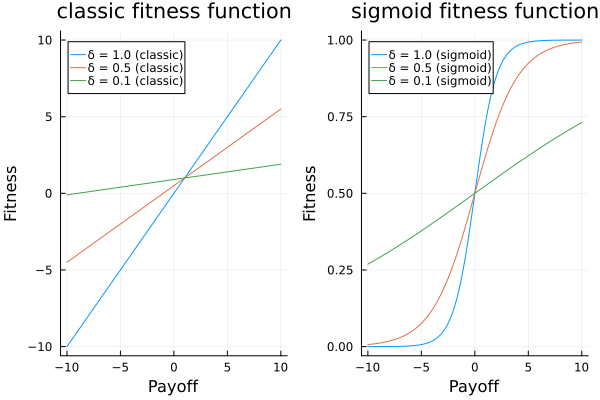

Test Summary: |Time
Visualization | None  2.1s


In [5]:
# 1.0 - δ + δ * payoff
@testset "classic_fitness" begin
    δ = 1.0
    for π = -10.0:0.1:10.0
        @test classic_fitness(π, δ) == π
    end
    δ = 0.1
    π_vec = [-10.0, -1.0, 0.0, 1.0, 2.0, 10.0]
    f_vec = [-0.1, 0.8, 0.9, 1.0, 1.1, 1.9]
    for (π, fitness) in zip(π_vec, f_vec)
        @test classic_fitness(π, δ) ≈ fitness
    end
end

# 1.0 / (1.0 + exp(-δ * payoff))
@testset "sigmoid_fitness" begin
    δ = 0.5
    @test sigmoid_fitness(1_000.0, δ) ≈ 1.0
    @test sigmoid_fitness(1.0, δ) ≈ 0.622459331
    @test sigmoid_fitness(0.0, δ) == 0.5
    @test sigmoid_fitness(-1.0, δ) ≈ 0.37754067
    @test sigmoid_fitness(-2_000.0, δ) ≈ 0.0
end

@testset "Visualization" begin
    π_vec = -10.0:0.1:10.0

    p_classic = plot(title = "classic fitness function", xl = "Payoff", yl = "Fitness")

    δ = 1.0
    f_vec = [classic_fitness(π, δ) for π in π_vec]
    plot!(π_vec, f_vec, label = "δ = $(δ) (classic)")

    δ = 0.5
    f_vec = [classic_fitness(π, δ) for π in π_vec]
    plot!(π_vec, f_vec, label = "δ = $(δ) (classic)")

    δ = 0.1
    f_vec = [classic_fitness(π, δ) for π in π_vec]
    plot!(π_vec, f_vec, label = "δ = $(δ) (classic)")

    p_sigmoid = plot(title = "sigmoid fitness function", xl = "Payoff", yl = "Fitness")

    δ = 1.0
    f_vec = [sigmoid_fitness(π, δ) for π in π_vec]
    plot!(π_vec, f_vec, label = "δ = $(δ) (sigmoid)")

    δ = 0.5
    f_vec = [sigmoid_fitness(π, δ) for π in π_vec]
    plot!(π_vec, f_vec, label = "δ = $(δ) (sigmoid)")

    δ = 0.1
    f_vec = [sigmoid_fitness(π, δ) for π in π_vec]
    plot!(π_vec, f_vec, label = "δ = $(δ) (sigmoid)")

    display(plot(p_classic, p_sigmoid))
end;

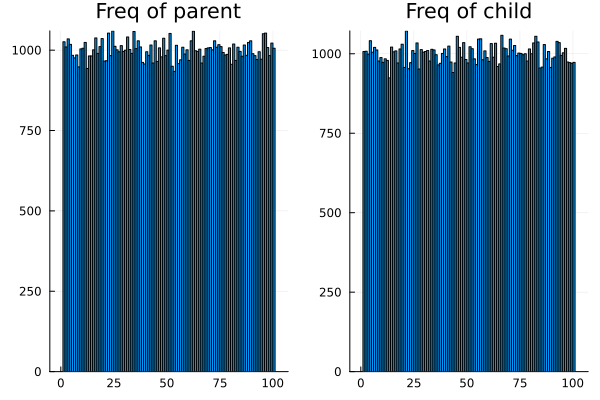

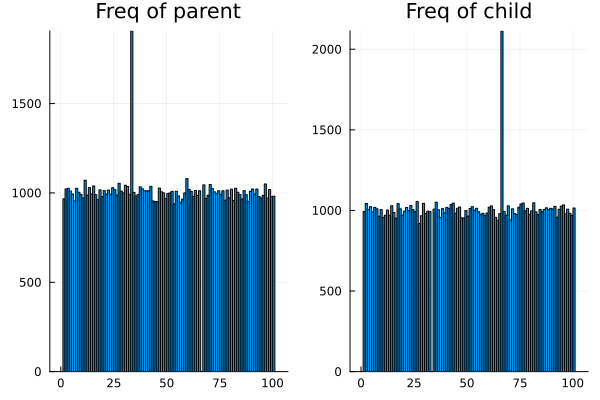

Test Summary:         |   Pass   Total  Time
pick_parent_and_child | 110010  110010  1.3s
Test Summary:           | Pass  Total  Time
death_and_reproduction! |   27     27  0.4s


In [6]:
@testset "pick_parent_and_child" begin
    @testset "uniform distribution" begin
        model = Model(N = 100, reproduction_rate = 0.1)
        id_pair_vec_vec = [pick_parent_and_child(model) for _ = 1:10_000]

        for (p_id_vec, c_id_vec) in id_pair_vec_vec
            @test length(p_id_vec) == length(c_id_vec) == 10
            for i = 1:10
                @test p_id_vec[i] != c_id_vec[i]
            end
        end

        p_id_vec = vcat([p_id_vec for (p_id_vec, _) in id_pair_vec_vec]...)
        c_id_vec = vcat([c_id_vec for (_, c_id_vec) in id_pair_vec_vec]...)

        p_freq = fit(Histogram, p_id_vec, 1:101).weights
        # test = ChisqTest(p_freq, fill(100, 100))
        # @test pvalue(test) > 0.1
        @test mean(p_freq) == 1000
        @test std(p_freq) < 150

        c_freq = fit(Histogram, c_id_vec, 1:101).weights
        # test2 = ChisqTest(c_freq, fill(100, 100))
        # @test pvalue(test2) > 0.1
        @test mean(c_freq) == 1000
        @test std(c_freq) < 150

        display(
            plot(
                histogram(p_id_vec, bins = 100, title = "Freq of parent", label = false),
                histogram(c_id_vec, bins = 100, title = "Freq of child", label = false),
            ),
        )
    end
    @testset "polarized situation" begin
        model = Model(N = 100, δ = 1.0, reproduction_rate = 0.1)
        model.agents.payoff[33] = 100
        model.agents.payoff[66] = -100
        id_pair_vec_vec = [pick_parent_and_child(model) for _ = 1:10_000]
        p_id_vec = vcat([p_id for (p_id, _) in id_pair_vec_vec]...)
        c_id_vec = vcat([c_id for (_, c_id) in id_pair_vec_vec]...)

        p_freq = fit(Histogram, p_id_vec, 1:101).weights
        @test mean(p_freq) == 1000
        @test p_freq[33] > 1800
        @test p_freq[66] < 100

        c_freq = fit(Histogram, c_id_vec, 1:101).weights
        @test mean(c_freq) == 1000
        @test c_freq[33] < 100
        @test c_freq[66] > 1800

        display(
            plot(
                histogram(p_id_vec, bins = 100, title = "Freq of parent", label = false),
                histogram(c_id_vec, bins = 100, title = "Freq of child", label = false),
            ),
        )
    end
end

function make_symmetric_matrix(N::Int)::Matrix
    mat = repeat(collect(0.0:(1/(N-1)):1.0), 1, N)
    mat -= Diagonal(mat)
    return (mat + mat') / 2
end

@testset "death_and_reproduction!" begin
    model = Model(N = 100, reproduction_rate = 0.03)
    model.rng = MersenneTwister(1)

    @testset "μ = 0.0" begin
        # before
        model.agents.strategy[[61, 75, 6]] .= C
        model.agents.strategy[[89, 67, 96]] .= D
        model.graph_weights = make_symmetric_matrix(100)

        # execution
        death_and_reproduction!(model)  # = ([61, 75, 6], [89, 67, 96])

        # after
        @test model.agents.strategy[[89, 67, 96]] == [C, C, C]
        @test model.graph_weights == transpose(model.graph_weights)  # check symmetry
        @test diag(model.graph_weights) == fill(0.0, 100)  # diagonal is 0.0

        model.graph_weights ./= Float16(1.022)  # for normalization
        _index = [x for x in 1:100 if !(x in [61, 89])]
        @test model.graph_weights[61, 89] == 1.0
        @test model.graph_weights[61, _index] == model.graph_weights[89, _index]

        _index = [x for x in 1:100 if !(x in [75, 67])]
        @test model.graph_weights[75, 67] == 1.0
        @test model.graph_weights[75, _index] == model.graph_weights[67, _index]

        _index = [x for x in 1:100 if !(x in [6, 96])]
        @test model.graph_weights[6, 96] == 1.0
        @test model.graph_weights[6, _index] == model.graph_weights[96, _index]

        # before
        model.agents.strategy[[60, 98, 35]] .= D
        model.agents.strategy[[5, 76, 32]] .= C
        model.graph_weights = make_symmetric_matrix(100)

        # execution
        death_and_reproduction!(model)  # = ([60, 98, 35], [5, 76, 32])

        # after
        @test model.agents.strategy[[5, 76, 32]] == [D, D, D]
        @test model.graph_weights == transpose(model.graph_weights)  # is symmetry
        @test diag(model.graph_weights) == fill(0.0, 100)  # diagonal is 0.0

        model.graph_weights ./= Float16(0.984)  # for normalization
        _index = [x for x in 1:100 if !(x in [5, 60])]
        @test model.graph_weights[60, 5] == model.graph_weights[5, 60] == 1.0
        @test model.graph_weights[60, _index] == model.graph_weights[5, _index]

        _index = [x for x in 1:100 if !(x in [98, 76])]
        @test model.graph_weights[98, 76] == 1.0
        @test model.graph_weights[98, _index] == model.graph_weights[76, _index]

        _index = [x for x in 1:100 if !(x in [35, 32])]
        @test model.graph_weights[35, 32] == 1.0
        @test model.graph_weights[35, _index] == model.graph_weights[32, _index]
    end

    @testset "μ = 1.0" begin
        # before
        model.agents.strategy[[69, 84, 74]] .= D
        model.agents.strategy[[20, 96, 4]] .= C
        model.μ = 1.0
        model.graph_weights = make_symmetric_matrix(100)

        # execution
        death_and_reproduction!(model)  # = ([69, 84, 74], [20, 96, 4])

        # after
        @test model.agents.strategy[[20, 96, 4]] == [C, C, C]
        @test model.graph_weights == transpose(model.graph_weights)  # check symmetry
        @test diag(model.graph_weights) == fill(0.0, 100)  # diagonal is 0.0

        model.graph_weights ./= Float16(0.9785)  # for normalization
        _index = [x for x in 1:100 if !(x in [69, 20])]
        @test model.graph_weights[69, 20] == 1.0
        @test model.graph_weights[69, _index] == model.graph_weights[20, _index]

        _index = [x for x in 1:100 if !(x in [84, 96])]
        @test model.graph_weights[84, 96] == 1.0
        @test model.graph_weights[84, _index] == model.graph_weights[96, _index]

        _index = [x for x in 1:100 if !(x in [74, 4])]
        @test model.graph_weights[74, 4] == 1.0
        @test model.graph_weights[74, _index] == model.graph_weights[4, _index]
    end
end;

# Logging

In [7]:
check_size(obj::Any)::String = "$(Base.summarysize(obj) / 1_024 / 1_024) MB"

@testset "make_output_df" begin
    df = make_output_df(10_000)
    @test size(df) == (10_000, 22)
end

@testset "log! (DataFrame)" begin
    output = make_output_df(7)
    model = Model(N = 10, initial_graph_weight = 1.0)

    # default
    log!(output, 1, model, 1)
    @test Vector(output[1, 1:10]) ==
          Float16[10.0, 1.0, 1.1, -0.1, 1.0, 0.1, 0.1, 0.01, 0.00, 1]
    @test Vector(output[1, 11:22]) ==
          [0.0, 0.0, 1.0, 0.0, 9.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 0.0]

    # cooperation rate and average payoff
    model.agents.strategy = repeat([C, D, D, D, D], 2)
    model.agents.payoff = 0.1:0.1:1.0
    log!(output, 2, model)
    @test Vector(output[2, 11:12]) == Float16[0.2, 0.55]

    # average and std of weights
    model = Model(N = 3)
    model.graph_weights = [0.0 1.0 2.0; 1.0 0.0 6.0; 2.0 6.0 0.0]
    log!(output, 3, model)
    @test Vector(output[3, 13:14]) ==
          [mean(Float16[1.0, 2.0, 6.0]), std(Float16[1.0, 2.0, 6.0])]

    # <k>, L, C
    ## regular graph
    model = Model(N = 1_000)
    g = random_regular_graph(1_000, 8)
    model.graph_weights = Matrix(adjacency_matrix(g))
    log!(output, 4, model, 1)
    @test Vector(output[4, 15:17]) ≈ [8.0, 3.6, 0.01] atol = 0.1

    ## scale free network (BA model)
    g = barabasi_albert(1_000, 2, seed = 1)
    model.graph_weights = Matrix(adjacency_matrix(g))
    log!(output, 5, model, 1)
    @test Vector(output[5, 15:17]) ≈ Float16[3.992, 4.038, 0.021] atol = 0.001

    # divided graph
    model = Model(N = 10)
    g = SimpleGraph(10)
    add_edge!(g, (1, 2))
    add_edge!(g, (2, 3))
    add_edge!(g, (3, 4))
    add_edge!(g, (5, 6))
    add_edge!(g, (6, 7))
    add_edge!(g, (8, 9))
    model.graph_weights = Matrix(adjacency_matrix(g))

    log!(output, 6, model, 1)

    expected_k = mean([1, 2, 2, 1, 1, 2, 1, 1, 1, 0])
    expected_L = mean([1, 2, 3, 1, 2, 1, 1, 2, 1, 1])
    @test Vector(output[6, 15:17]) ≈ [expected_k, expected_L, 0.0] atol = 0.1

    # component (コンポーネント数, コンポーネントサイズの平均, 最大, 最小, 標準偏差)
    @test Vector(output[6, 18:22]) ==
          Float16[4.0, mean([4, 3, 2, 1]), 4.0, 1.0, std([4, 3, 2, 1])]
    @test Vector(output[4, 18:22]) == Float16[1.0, 1000.0, 1000.0, 1000.0, 0.0]
    @test Vector(output[5, 18:22]) == Float16[1.0, 1000.0, 1000.0, 1000.0, 0.0]
    @test Vector(output[3, 18:22]) == Float16[1.0, 3.0, 3.0, 3.0, 0.0]
end;

Test Summary:  | Pass  Total  Time
make_output_df |    1      1  0.0s
Test Summary:    | Pass  Total  Time
log! (DataFrame) |   11     11  2.1s


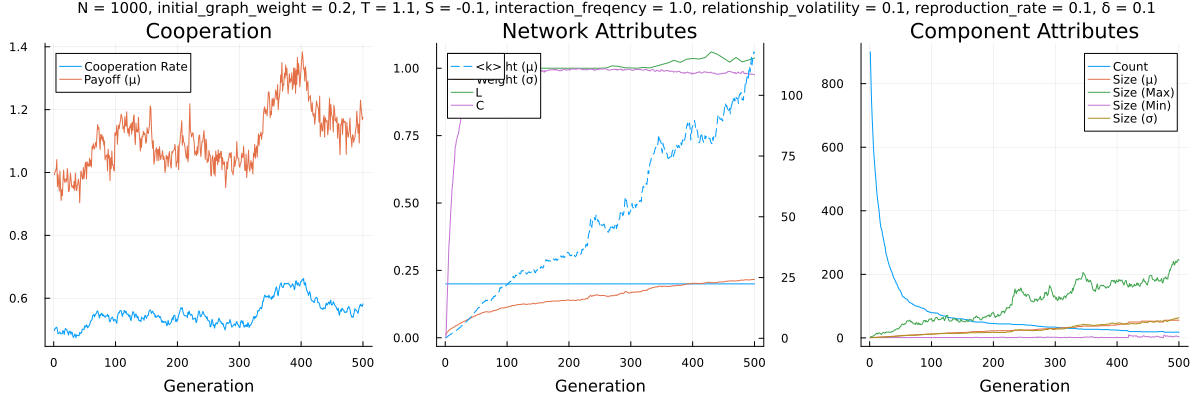

In [8]:
df = Simulation.run(1_000, 1.1, -0.1, 1.0, 0.2, 0.1, 0.1, 0.01, 500)
plot_output_df(df)